In [19]:
#library 
import pandas as pd 
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
from time import time
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.metrics import smape

#for korean
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)
%config InlineBackend.figure_format='retina'

#show .5f
pd.options.display.float_format = '{:.5f}'.format
#show all columns
pd.set_option('display.max.columns', None)

In [20]:
df = pd.read_csv("Z:/team/dataset/제공데이터_merge+기온,강수량,cpi,gdp,천연가스수입.csv",index_col='Unnamed: 0',parse_dates=True)
sample_submission = pd.read_csv("Z:/team/dataset/submission_sample.csv")
df.drop(['도시가스(톤)_총합(민수용+산업용)'],1,inplace=True)
enc = LabelEncoder()
df['QUARTER']=enc.fit_transform(df['QUARTER'])

In [21]:
df

,YEAR,MONTH,도시가스(톤)_민수용,도시가스(톤)_산업용,민수용비중,산업용비중,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),QUARTER,QVA(제조업부가가치/단위:십억원),평균기온,최저기온,최고기온,강수량,소비자 물가지수(cpi),"국내총생산(시장가격, GDP)",천연가스 수입 중량 합계
Unnamed: 0,,,,,,,,,,,,,,,,,,
1996-01-01,1996,1,605519.00000,83809.00000,0.87842,0.12158,0.97000,26.94000,27.86000,0,36550.30000,-1.30000,-6.30000,4.50000,29.50000,53.28900,118011.10000,969744
1996-02-01,1996,2,566323.00000,70427.00000,0.88940,0.11060,0.93000,26.94000,29.04000,0,36550.30000,-1.10000,-6.40000,5.20000,11.40000,53.49900,118011.10000,859127
1996-03-01,1996,3,477514.00000,62652.00000,0.88401,0.11599,0.96000,26.94000,27.99000,0,36550.30000,4.40000,-0.70000,10.00000,121.20000,53.86200,118011.10000,967455
1996-04-01,1996,4,337794.00000,47050.00000,0.87774,0.12226,0.94000,26.94000,28.74000,1,37152.40000,9.90000,3.50000,16.30000,56.90000,54.22600,121036.10000,800687
1996-05-01,1996,5,184522.00000,30709.00000,0.85732,0.14268,0.92000,26.94000,29.18000,1,37152.40000,16.80000,10.60000,23.50000,42.20000,54.53800,121036.10000,738303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,2020,8,398661.00000,457970.00000,0.46538,0.53462,0.86000,72.93000,84.71000,2,121747.50000,26.40000,23.50000,30.50000,420.80000,100.19000,489772.80000,1956398
2020-09-01,2020,9,380235.00000,525619.00000,0.41975,0.58025,0.80000,65.24000,81.26000,2,121747.50000,20.10000,16.30000,24.90000,219.10000,100.74000,489772.80000,2934537
2020-10-01,2020,10,616682.00000,600890.00000,0.50649,0.49352,0.76000,59.16000,78.13000,3,124740.40000,13.70000,8.30000,20.00000,10.50000,100.18000,494927.70000,3848453


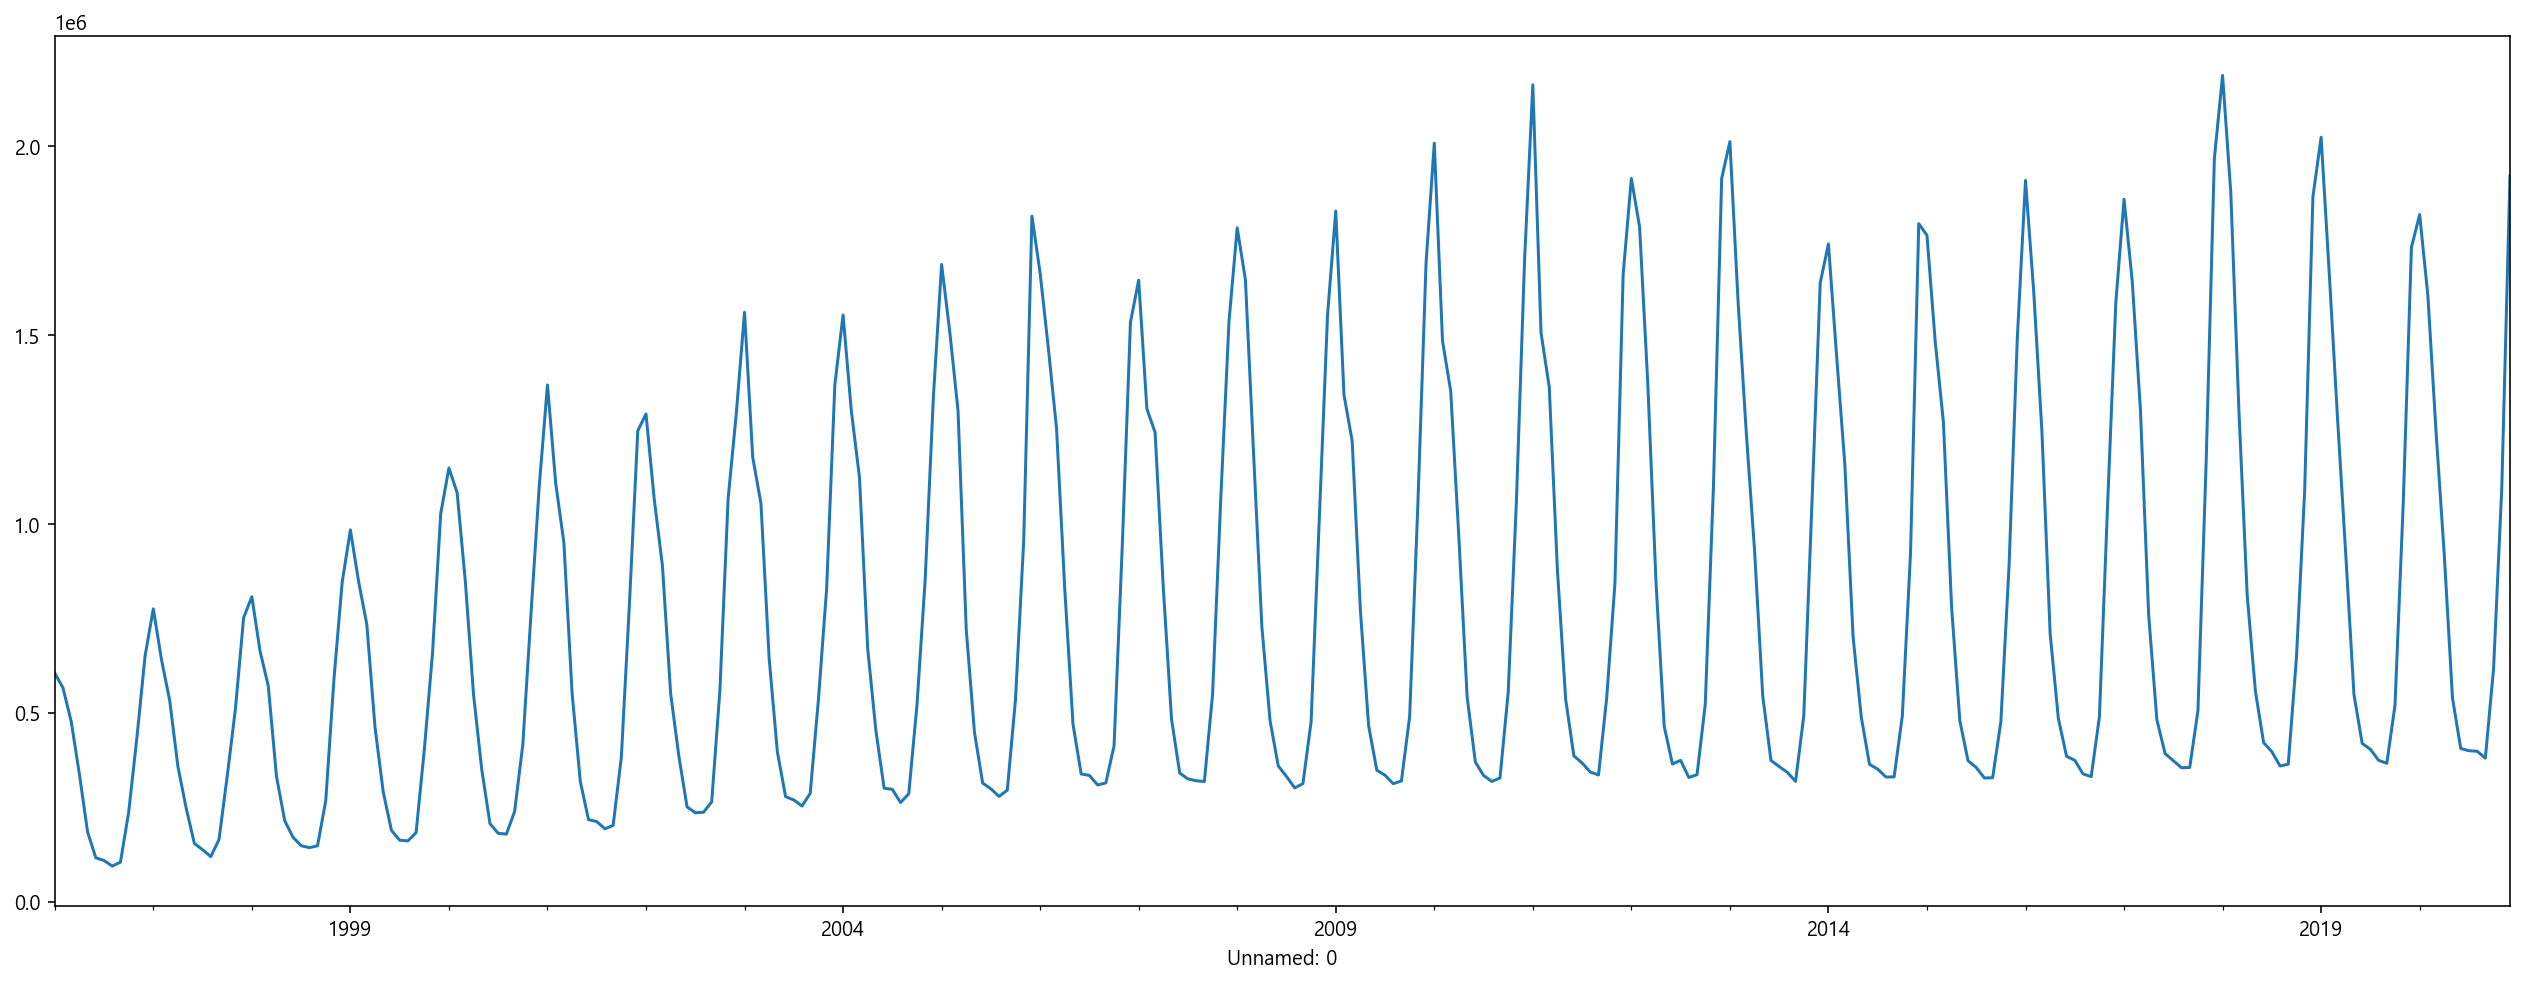

In [22]:
plt.figure(figsize=(22,8))
df['도시가스(톤)_민수용'].plot();

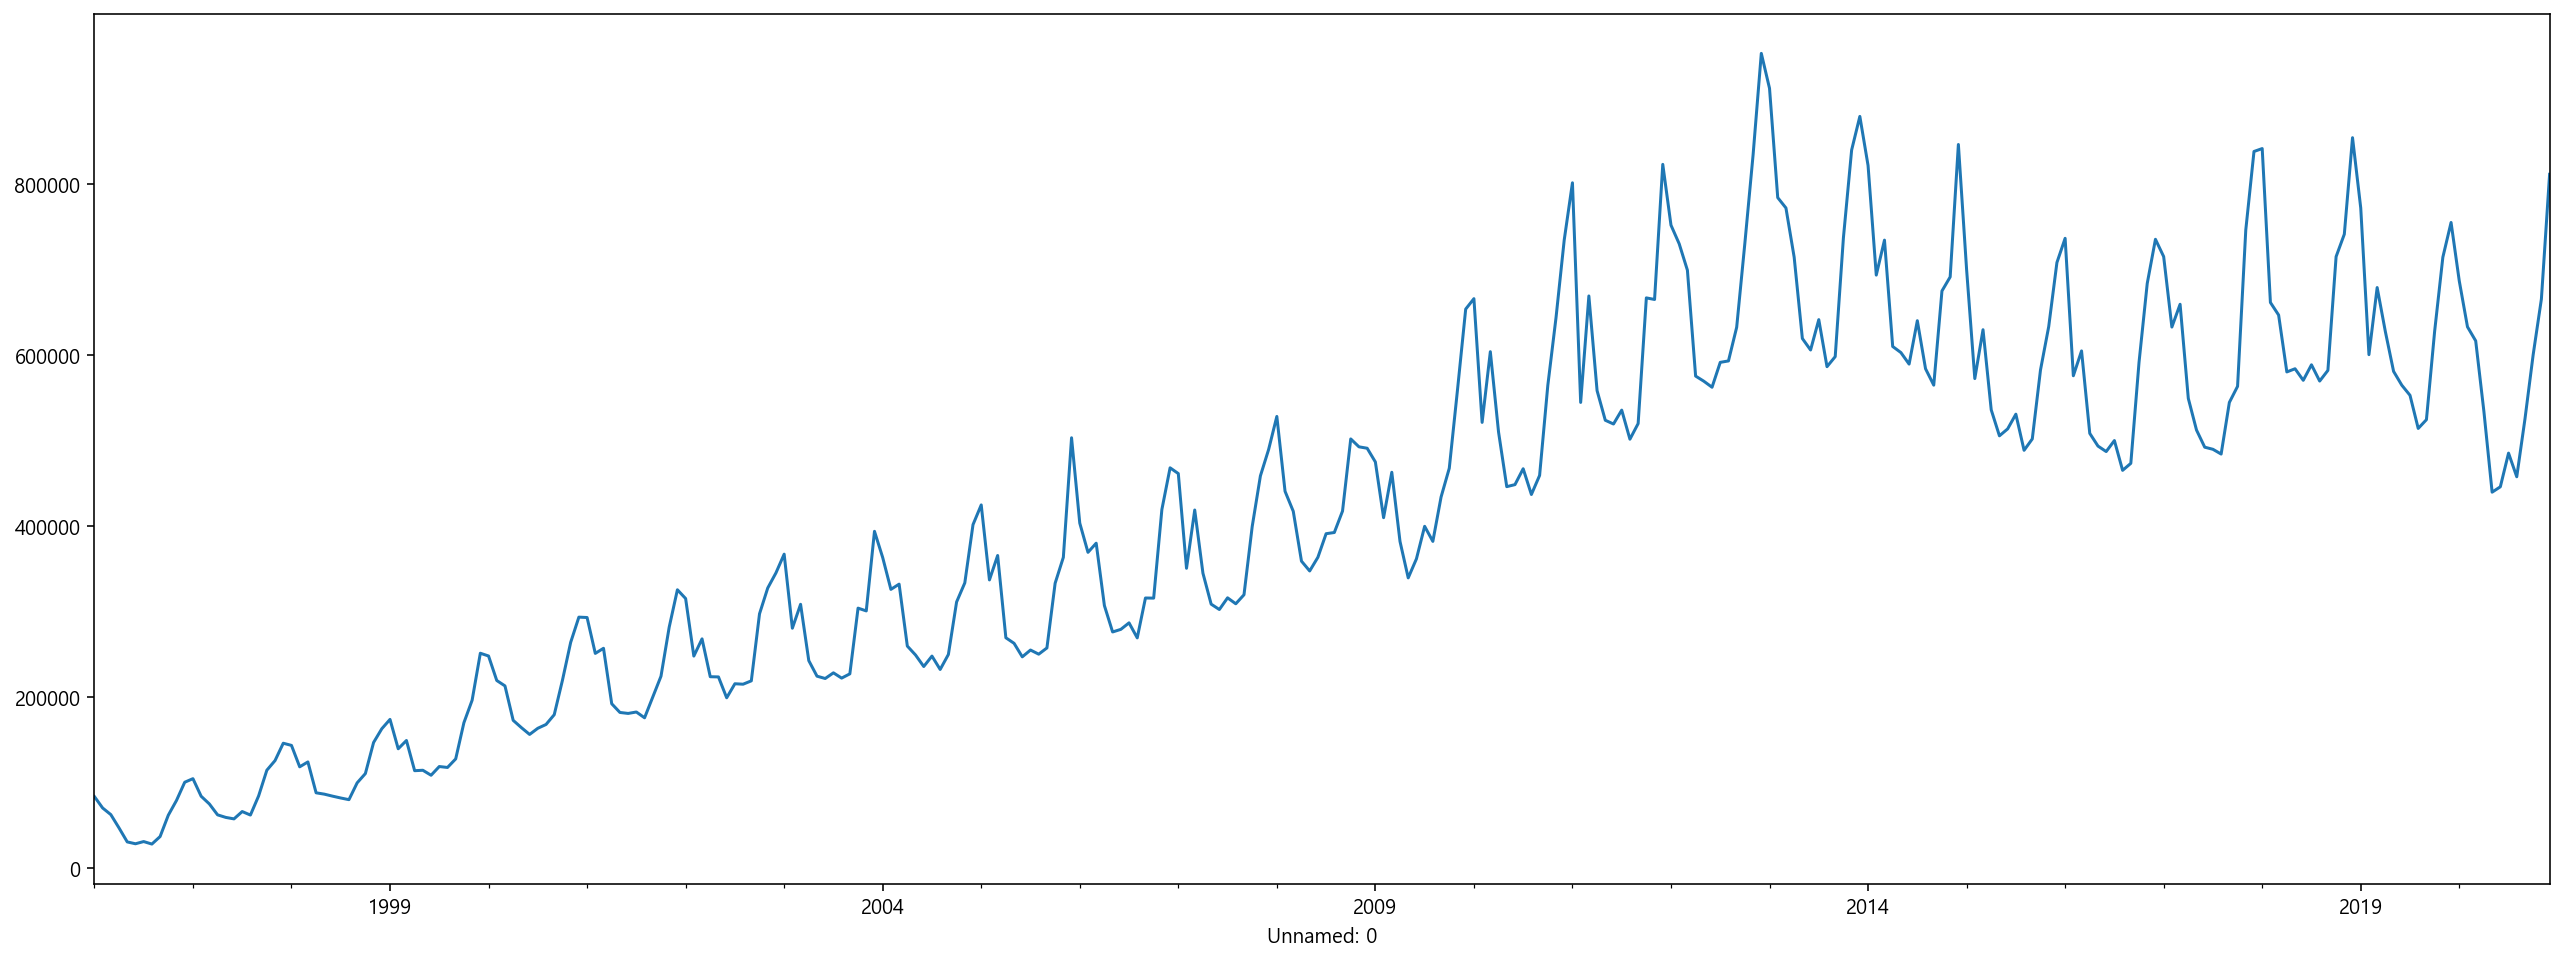

In [23]:
plt.figure(figsize=(22,8))
df['도시가스(톤)_산업용'].plot();

In [24]:
train = df.iloc[:276]
test = df.iloc[276:]

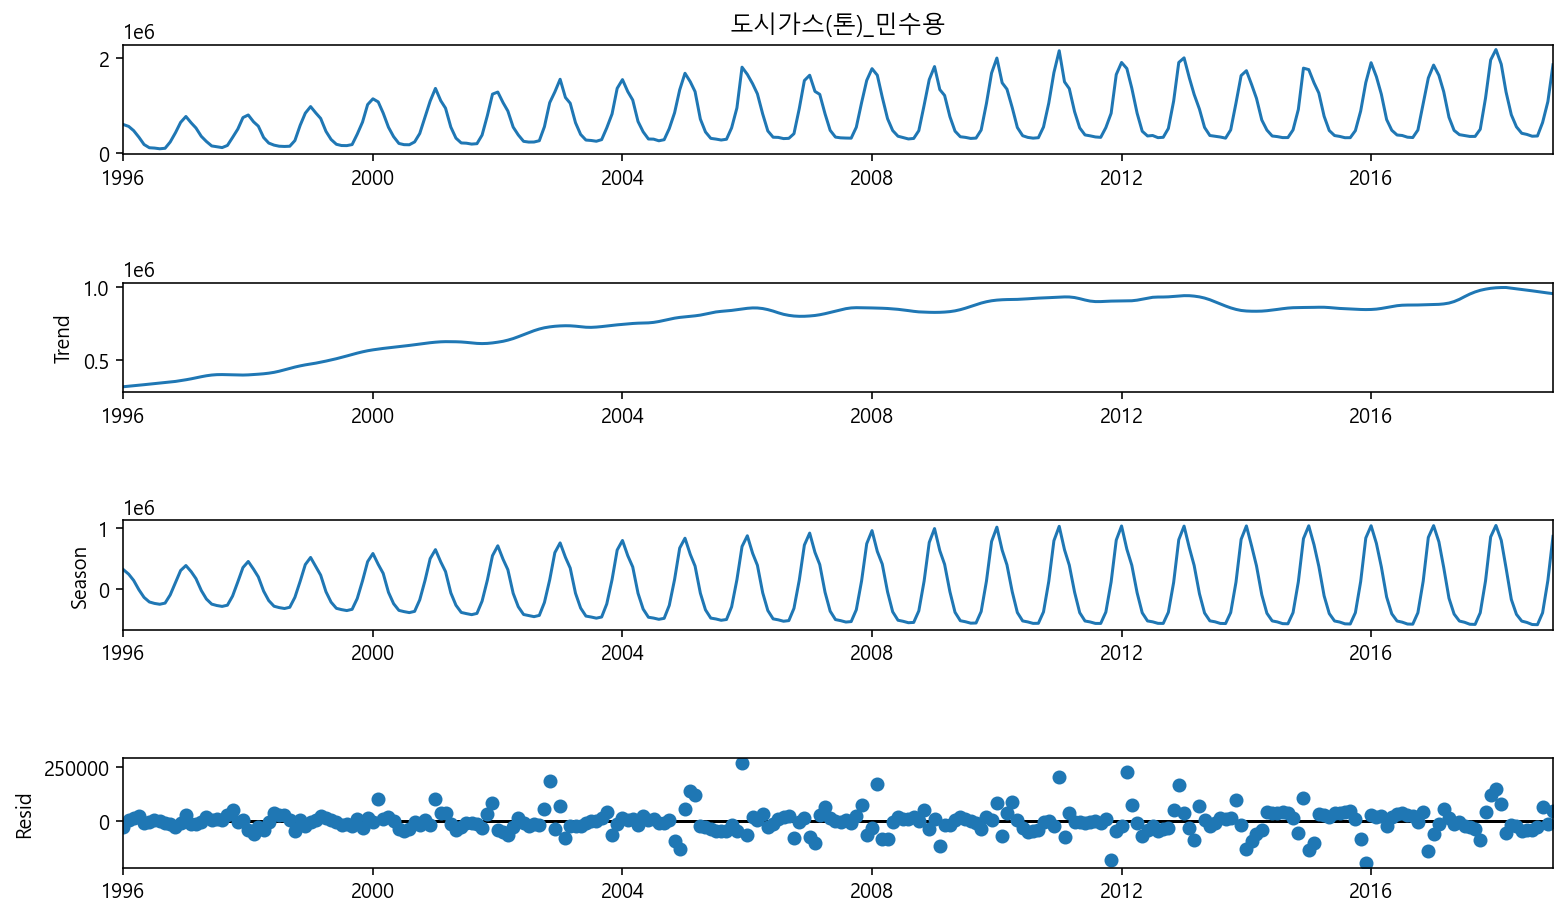

In [25]:
#STL
stl = STL(train['도시가스(톤)_민수용'],seasonal=13)
res = stl.fit()
fig  = res.plot().set_size_inches(12,7)

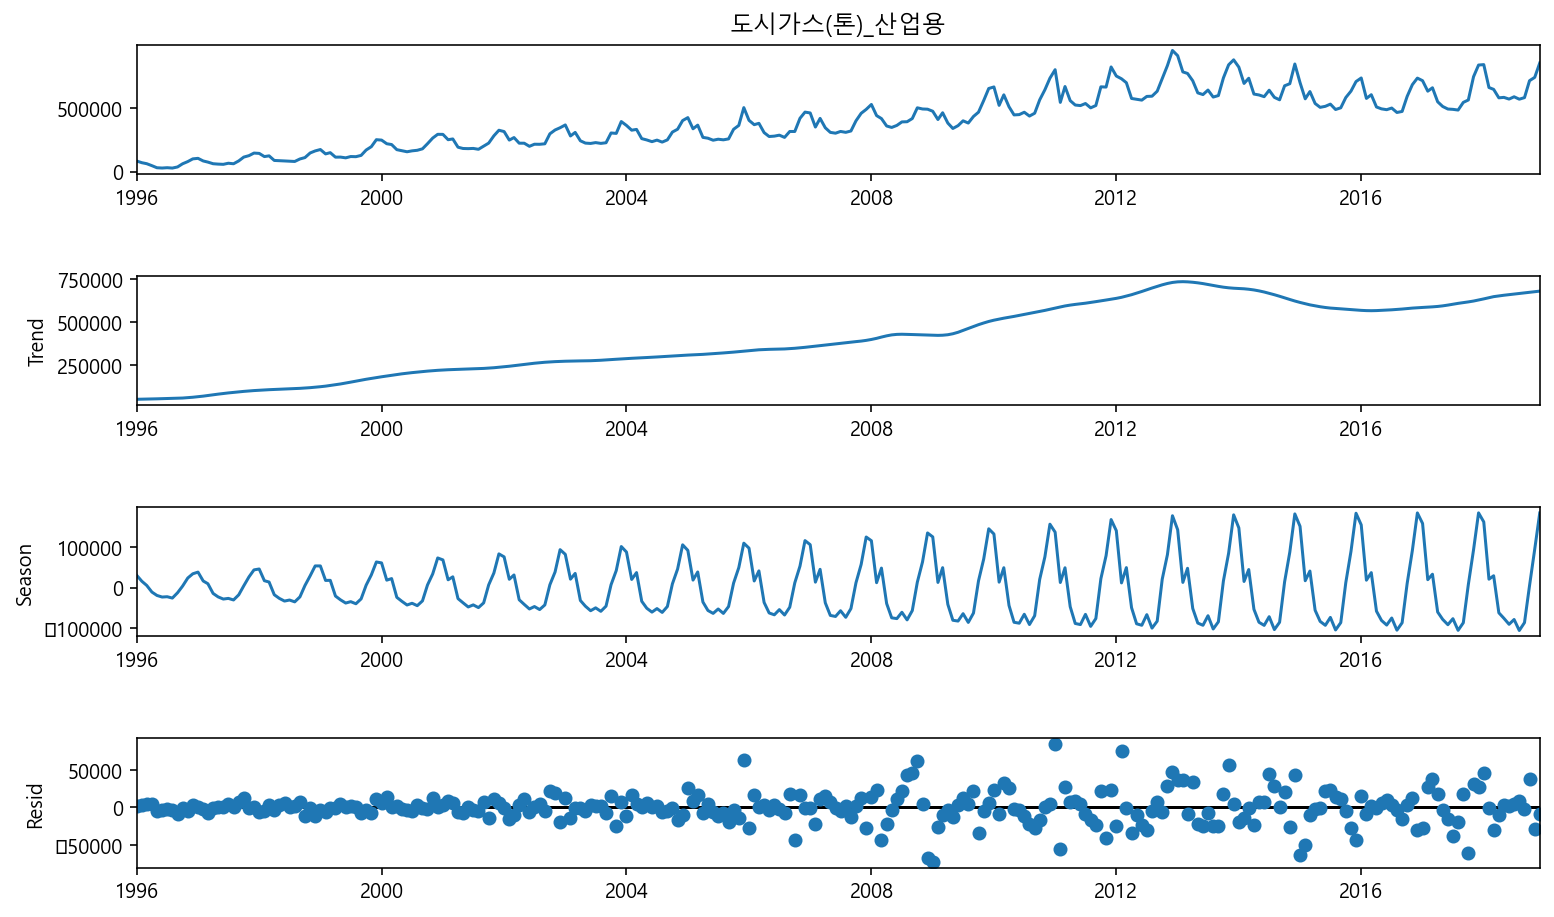

In [6]:
stl = STL(train['도시가스(톤)_산업용'],seasonal=13)
res = stl.fit()
fig  = res.plot().set_size_inches(12,7)

In [7]:
# fold = TimeSeriesSplit(n_splits=4)
# smape_score= []
# for train_idx, test_idx in fold.split(df['도시가스(톤)_산업용']):
#     cv_train, cv_test =df['도시가스(톤)_산업용'].iloc[train_idx],df['도시가스(톤)_산업용'].iloc[test_idx]
#     model=SARIMAX(cv_train.values,order=(1,1,0),seasonal_order=(1,1,1,12)).fit()
#     pred = model.predict(start=len(cv_train), end=len(cv_train)+len(cv_test)-1, dynamic=False, typ='levels')
#     true_values = cv_test.values
#     smape_score.append(smape(true_values, pred))
# print("4 SPLIT  : " ,np.mean(smape_score))

# ACF, PACF

Before Log + Diffrencing


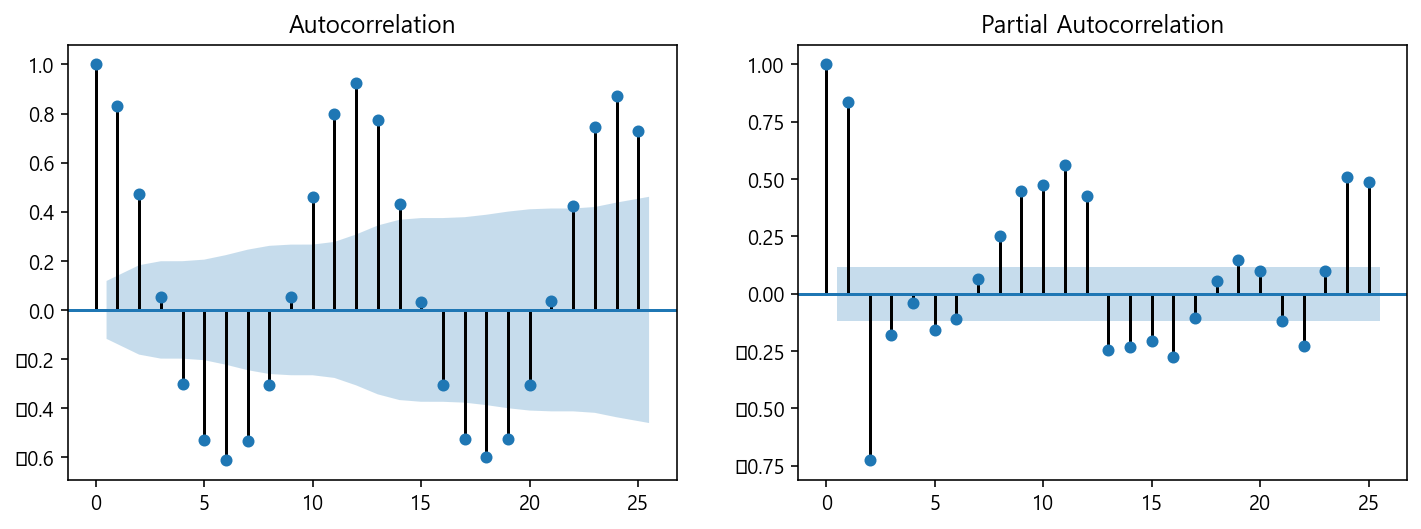

After Log + Differencing


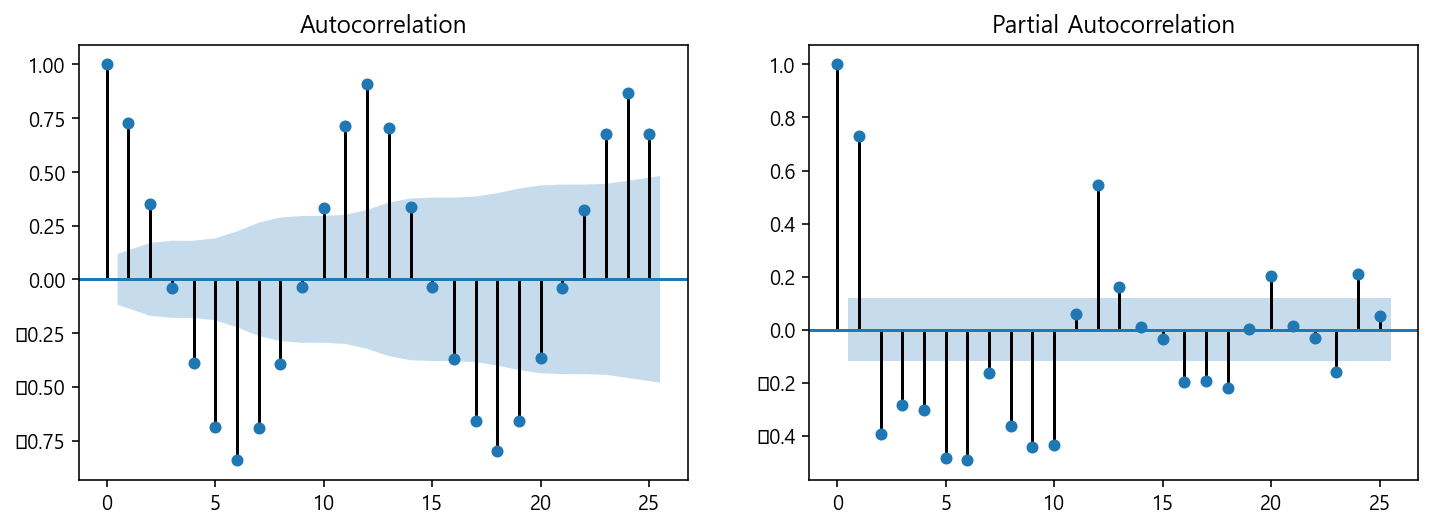

In [26]:
f,ax=plt.subplots(1,2,figsize=(12,4))
print("Before Log + Diffrencing")
plot_acf(train['도시가스(톤)_민수용'],ax=ax[0]);
plot_pacf(train['도시가스(톤)_민수용'],ax=ax[1]);
plt.show()

print("After Log + Differencing")
f,ax=plt.subplots(1,2,figsize=(12,4))
plot_acf(np.log1p(train['도시가스(톤)_민수용']).diff().dropna(),ax=ax[0]);
plot_pacf(np.log1p(train['도시가스(톤)_민수용']).diff().dropna(),ax=ax[1]);

Before Log + Diffrencing


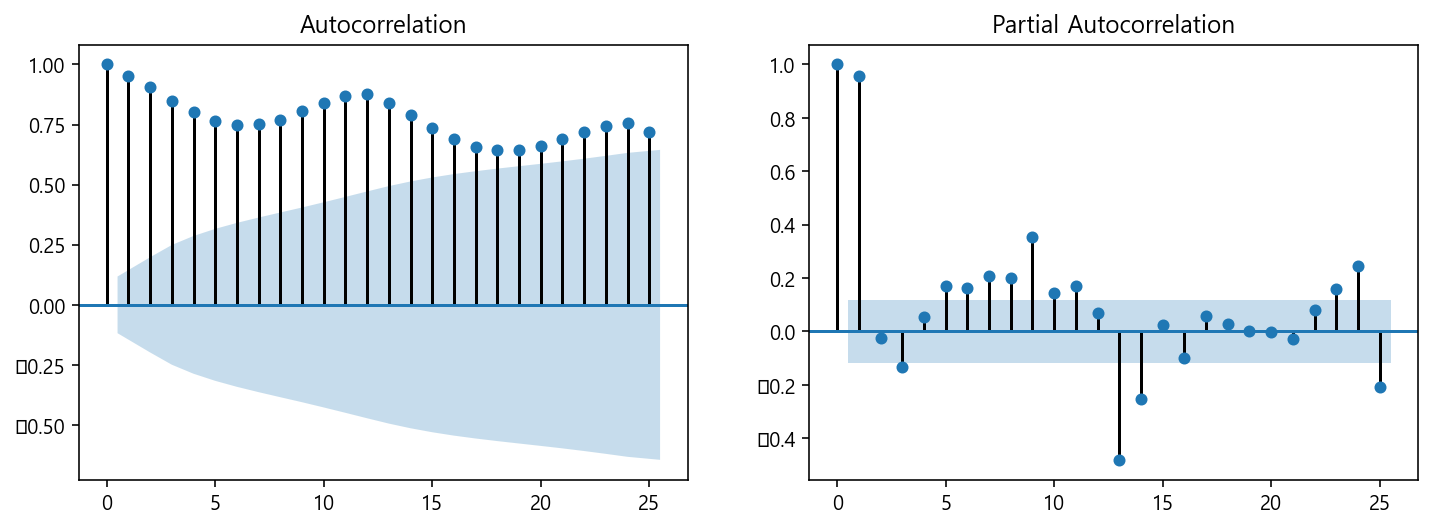

After Log + Differencing


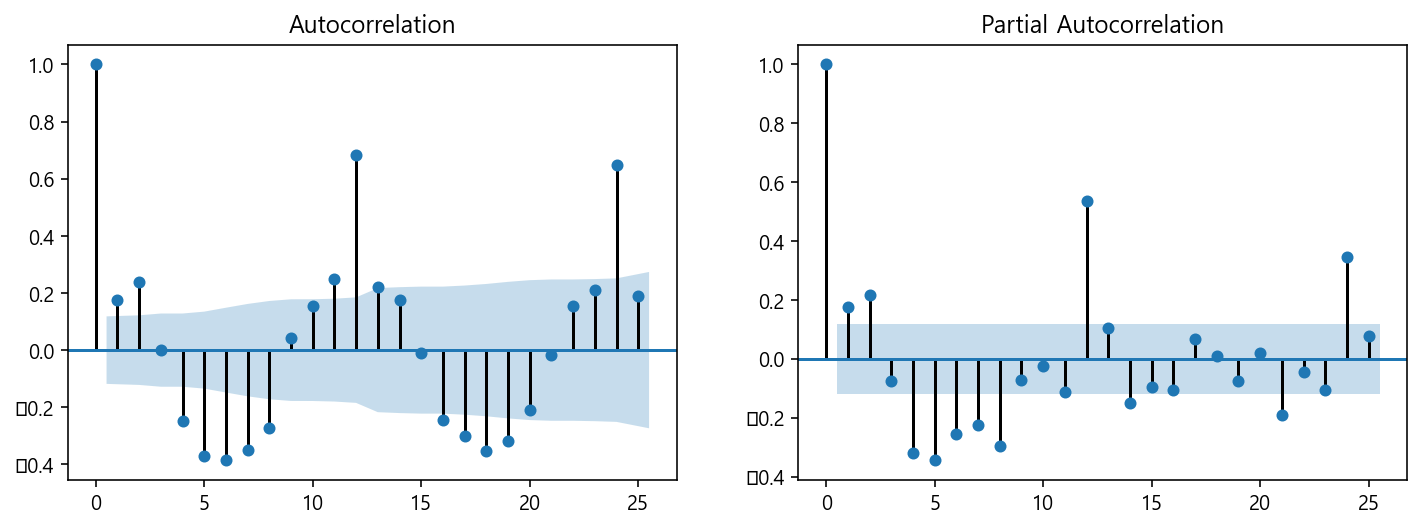

In [27]:
f,ax=plt.subplots(1,2,figsize=(12,4))
print("Before Log + Diffrencing")
plot_acf(train['도시가스(톤)_산업용'],ax=ax[0]);
plot_pacf(train['도시가스(톤)_산업용'],ax=ax[1]);
plt.show()

print("After Log + Differencing")
f,ax=plt.subplots(1,2,figsize=(12,4))
plot_acf(np.log1p(train['도시가스(톤)_산업용']).diff().dropna(),ax=ax[0]);
plot_pacf(np.log1p(train['도시가스(톤)_산업용']).diff().dropna(),ax=ax[1]);

In [28]:
#adfuller
def adf_test(series, title=''):
    print(f'Augmented Dickey fuller test: {title}')
    result=adfuller(series.dropna(),autolag='AIC')
    labels=['ADF test statistic', 'p-value','# lags use', '# observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null H")
        print("Reject the null H")
        print('Data has no unit root and is stationary')
    else:
        print('weak evidence against the null H')
        print('fail to reject the null h')
        print('data has a unit root and is non-stationary')

In [29]:
#정상성 확인_산업용
adf_test(train['도시가스(톤)_산업용'])

Augmented Dickey fuller test: 
ADF test statistic      -1.24831
p-value                  0.65248
# lags use              15.00000
# observations         260.00000
critical value (1%)     -3.45575
critical value (5%)     -2.87272
critical value (10%)    -2.57273
weak evidence against the null H
fail to reject the null h
data has a unit root and is non-stationary


In [12]:
#1차차분
adf_test(train['도시가스(톤)_산업용'].diff())

Augmented Dickey fuller test: 
ADF test statistic      -3.23295
p-value                  0.01816
# lags use              14.00000
# observations         260.00000
critical value (1%)     -3.45575
critical value (5%)     -2.87272
critical value (10%)    -2.57273
Strong evidence against the null H
Reject the null H
Data has no unit root and is stationary


In [13]:
#정상성 확인_민수용
adf_test(train['도시가스(톤)_민수용'])

Augmented Dickey fuller test: 
ADF test statistic      -2.30168
p-value                  0.17143
# lags use              13.00000
# observations         262.00000
critical value (1%)     -3.45556
critical value (5%)     -2.87264
critical value (10%)    -2.57268
weak evidence against the null H
fail to reject the null h
data has a unit root and is non-stationary


In [14]:
#1차차분
adf_test(train['도시가스(톤)_민수용'])

Augmented Dickey fuller test: 
ADF test statistic      -2.30168
p-value                  0.17143
# lags use              13.00000
# observations         262.00000
critical value (1%)     -3.45556
critical value (5%)     -2.87264
critical value (10%)    -2.57268
weak evidence against the null H
fail to reject the null h
data has a unit root and is non-stationary


# IND

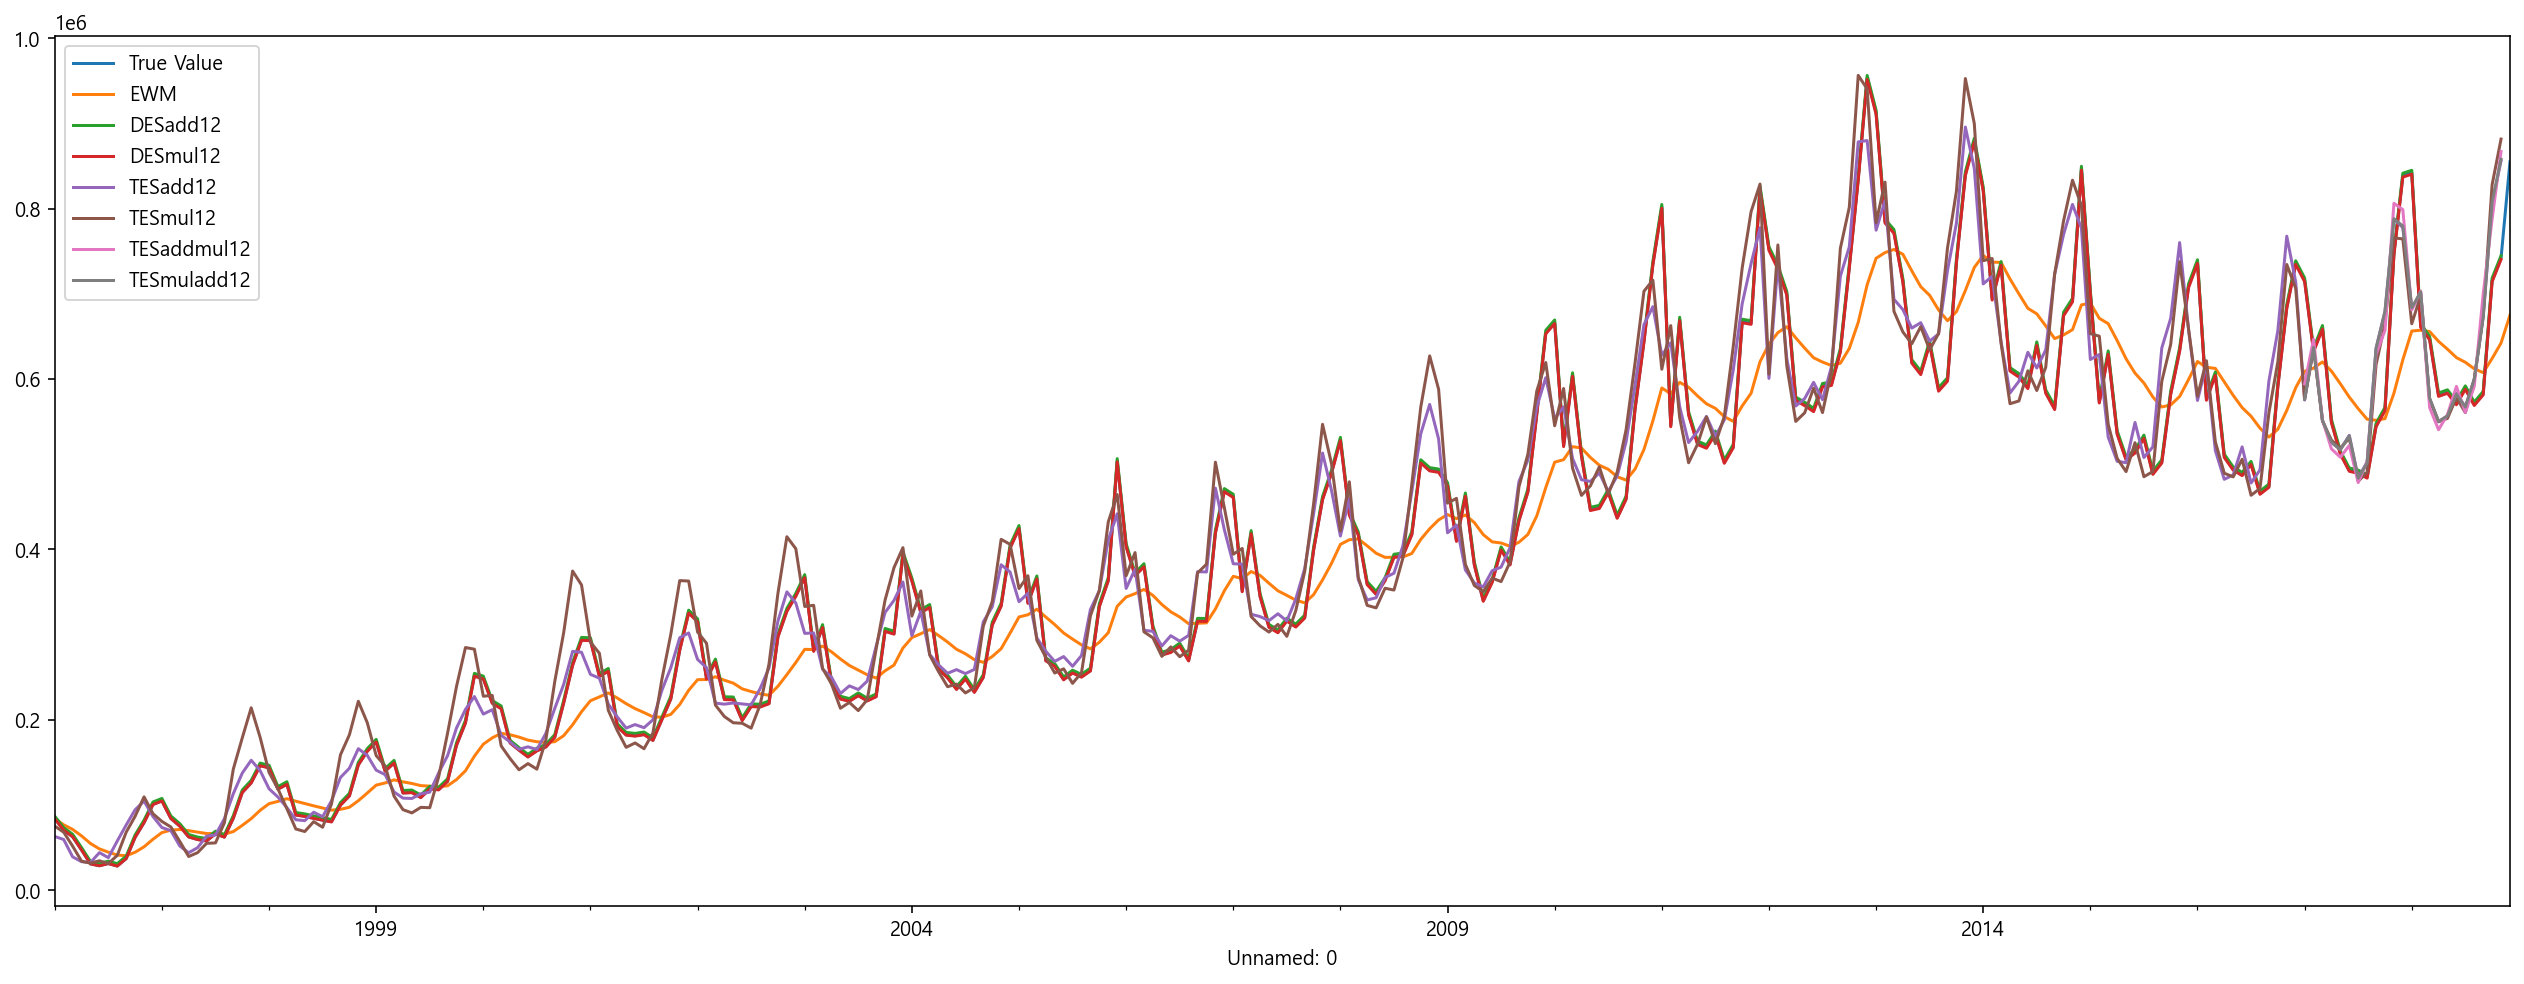

In [30]:
plt.figure(figsize=(22,8))
span=12
alpha = 2/(span+1)

train['도시가스(톤)_산업용'].plot(legend=True,label='True Value')
train['도시가스(톤)_산업용'].ewm(alpha=alpha).mean().plot(legend=True,label='EWM')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add').fit().fittedvalues.shift(-1).plot(legend=True, label='DESadd12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul').fit().fittedvalues.shift(-1).plot(legend=True, label='DESmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).plot(legend=True, label='TESadd12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).plot(legend=True, label='TESmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-24:].plot(legend=True, label='TESaddmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-24:].plot(legend=True, label='TESmuladd12')
plt.show();

C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: Valu

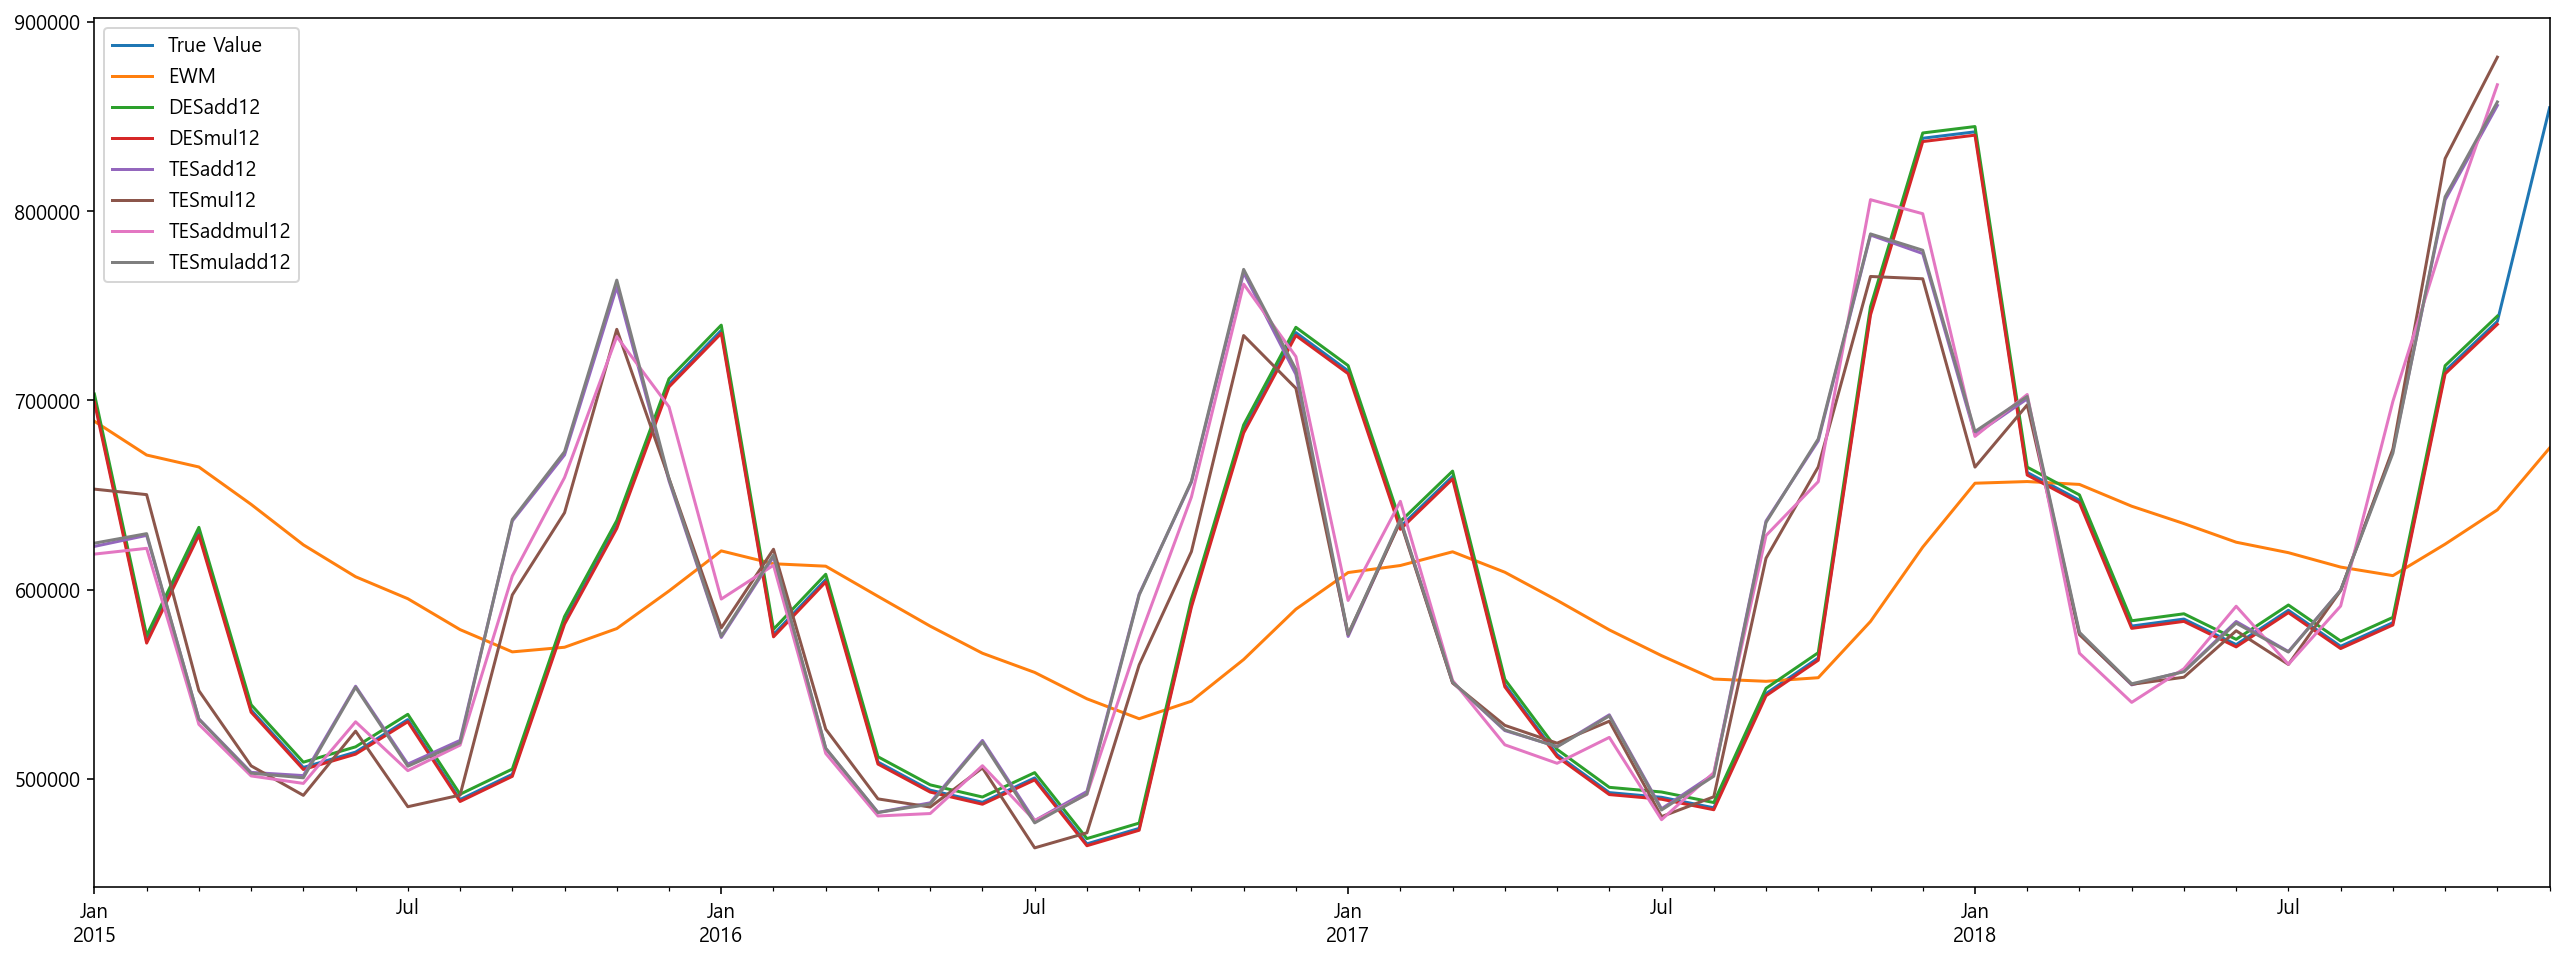

In [16]:
#산업용 2015-01-01 ~ 2018-12-01
plt.figure(figsize=(22,8))
train['도시가스(톤)_산업용'].iloc[-48:].plot(legend=True,label='True Value')
train['도시가스(톤)_산업용'].ewm(alpha=alpha).mean().iloc[-48:].plot(legend=True,label='EWM')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add').fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='DESadd12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul').fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='DESmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESadd12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESaddmul12')
ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESmuladd12')

In [17]:
Ind_DES_add = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add').fit()
Ind_DES_mul = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul').fit()
Ind_TES_add = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='add',seasonal_periods=12).fit()
Ind_TES_mul = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='mul',seasonal_periods=12).fit()
Ind_TES_add_mul = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='add',seasonal='mul',seasonal_periods=12).fit()
Ind_TES_mul_add = ExponentialSmoothing(train['도시가스(톤)_산업용'], trend='mul',seasonal='add',seasonal_periods=12).fit()

Ind_DES_add_pred = Ind_DES_add.predict(start=len(train), end=len(train)+len(test)-1)
Ind_DES_mul_pred = Ind_DES_mul.predict(start=len(train), end=len(train)+len(test)-1)
Ind_TES_add_pred = Ind_TES_add.predict(start=len(train), end=len(train)+len(test)-1)
Ind_TES_mul_pred = Ind_TES_mul.predict(start=len(train), end=len(train)+len(test)-1)
Ind_TES_add_mul_pred = Ind_TES_add_mul.predict(start=len(train), end=len(train)+len(test)-1)
Ind_TES_mul_add_pred = Ind_TES_mul_add.predict(start=len(train), end=len(train)+len(test)-1)

print("IND_DES_ADD * SMAPE :",smape(Ind_DES_add_pred, test['도시가스(톤)_산업용']))
print("IND_DES_MUL * SMAPE :",smape(Ind_DES_mul_pred, test['도시가스(톤)_산업용']))
print("IND_TES_ADD * SMAPE :",smape(Ind_TES_add_pred, test['도시가스(톤)_산업용']))
print("IND_TES_MUL * SMAPE :",smape(Ind_TES_mul_pred, test['도시가스(톤)_산업용']))
print("IND_TES_ADD_MUL * SMAPE :",smape(Ind_TES_add_mul_pred, test['도시가스(톤)_산업용']))
print("IND_TES_MUL_ADD * SMAPE :",smape(Ind_TES_mul_add_pred, test['도시가스(톤)_산업용']))

C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: Valu

IND_DES_ADD * SMAPE : 39.76156610732479
IND_DES_MUL * SMAPE : 33.45883928738599
IND_TES_ADD * SMAPE : 14.670260056514584
IND_TES_MUL * SMAPE : 15.480876883272666
IND_TES_ADD_MUL * SMAPE : 13.539841847383338
IND_TES_MUL_ADD * SMAPE : 15.401221910912705


## CIVIL

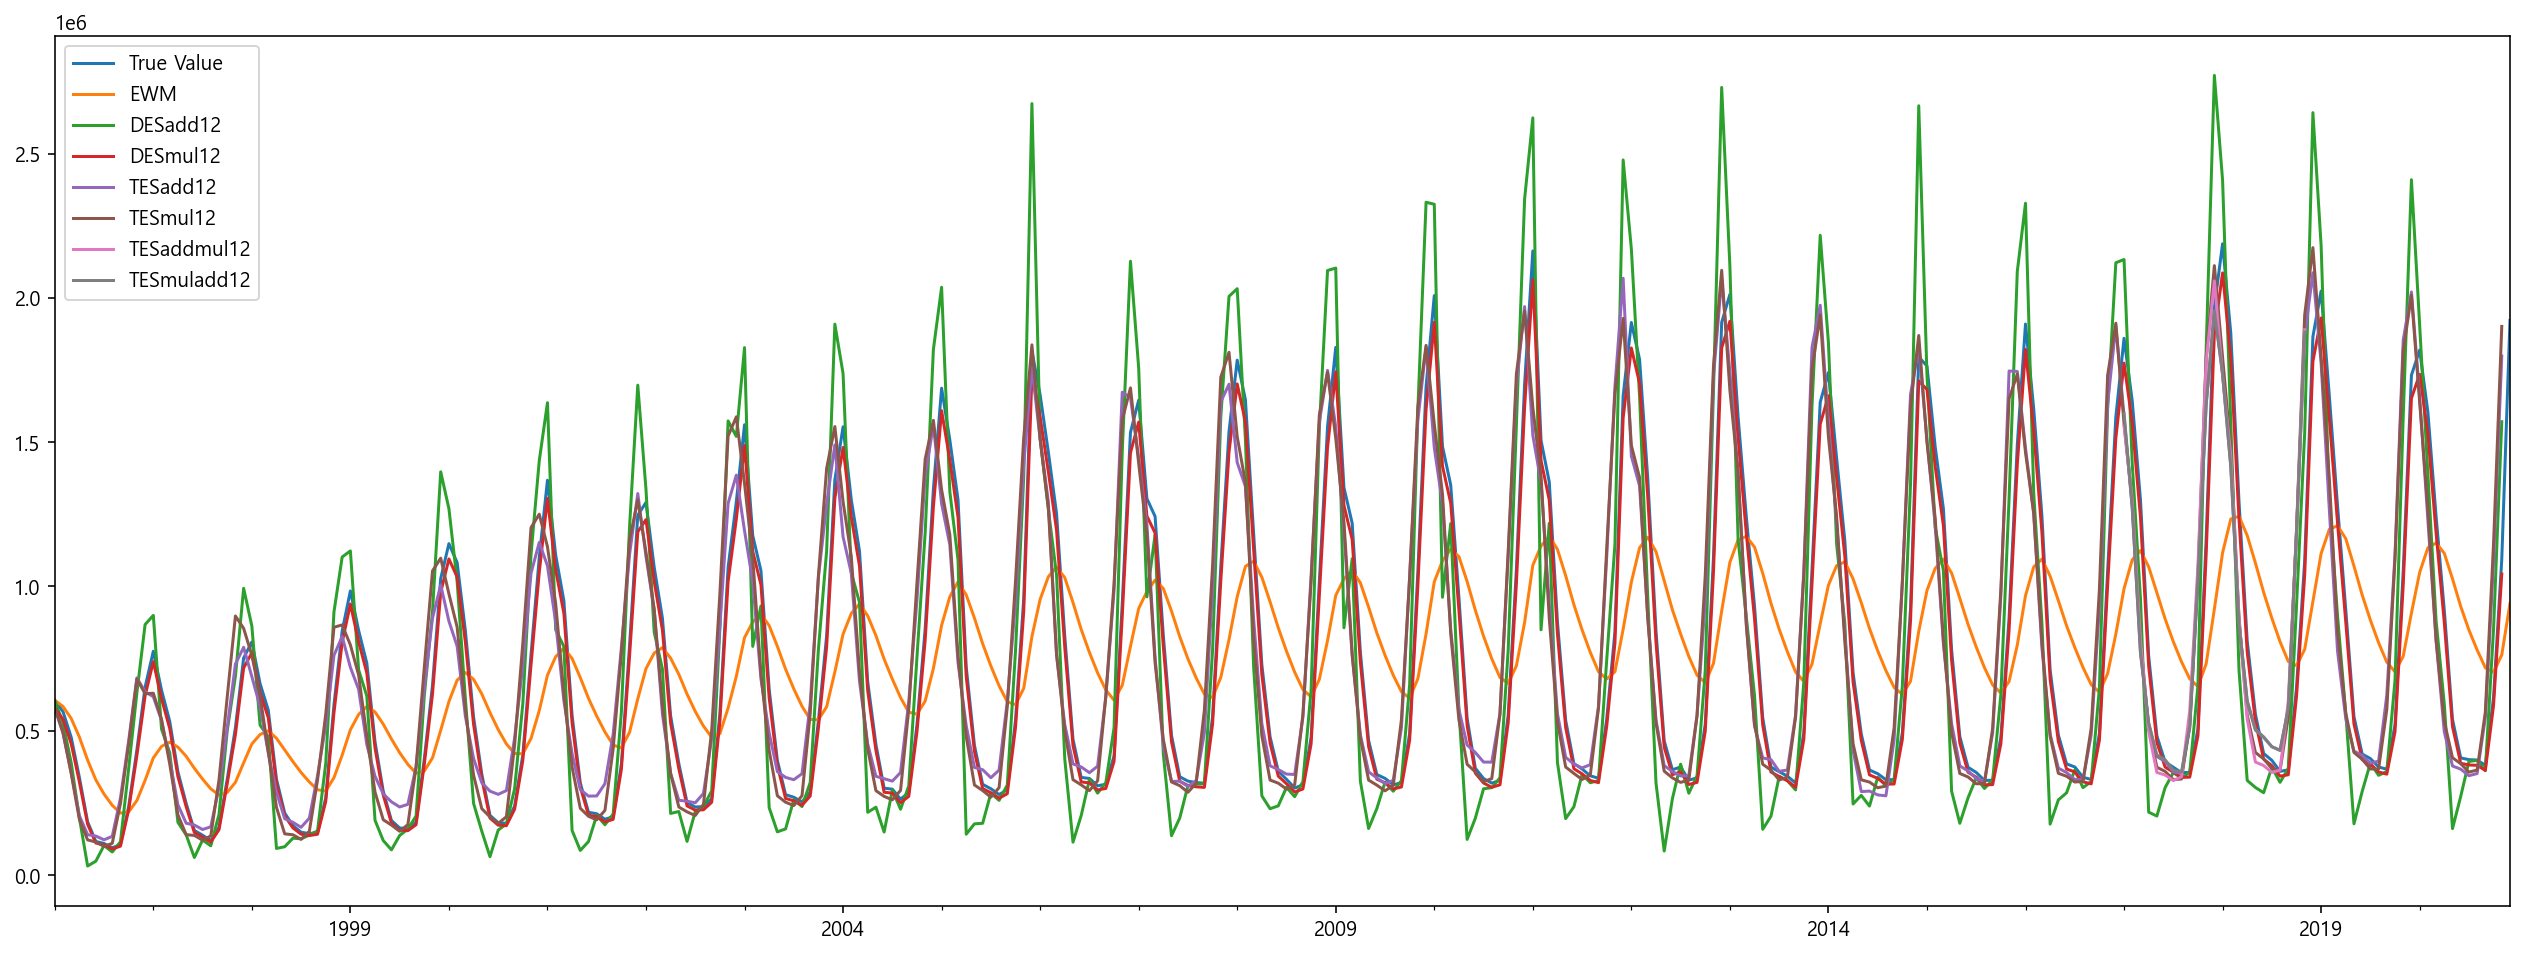

In [22]:
plt.figure(figsize=(22,8))
span=12
alpha = 2/(span+1)


df['도시가스(톤)_민수용'].plot(legend=True,label='True Value')
df['도시가스(톤)_민수용'].ewm(alpha=alpha).mean().plot(legend=True,label='EWM')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='add').fit().fittedvalues.shift(-1).plot(legend=True, label='DESadd12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='mul').fit().fittedvalues.shift(-1).plot(legend=True, label='DESmul12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).plot(legend=True, label='TESadd12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).plot(legend=True, label='TESmul12')
ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='add',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-24:].plot(legend=True, label='TESaddmul12')
ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='mul',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-24:].plot(legend=True, label='TESmuladd12')
plt.show();

C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning

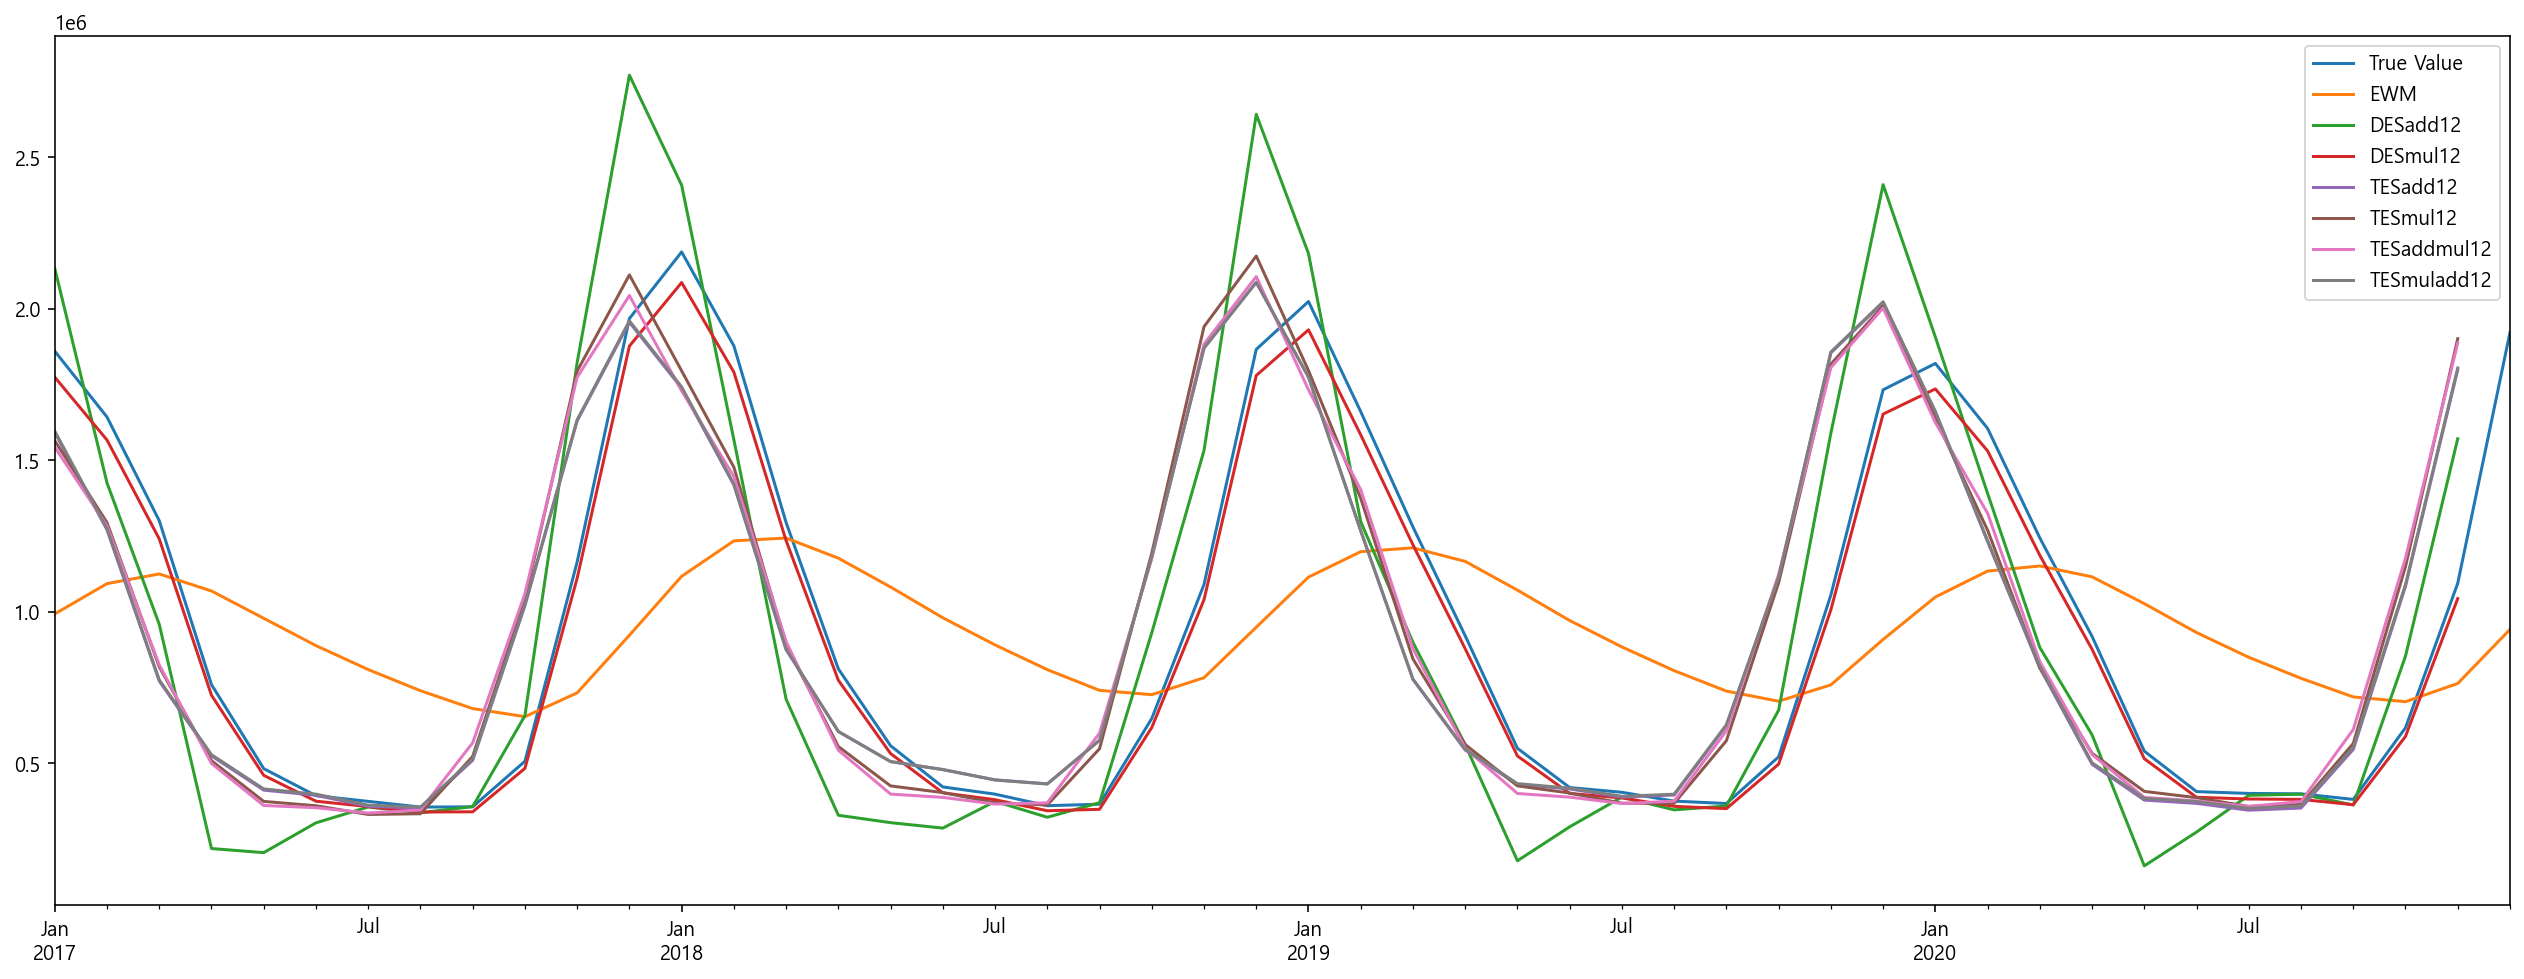

In [19]:
#민수용 2015-01-01 ~ 2018-12-01
plt.figure(figsize=(22,8))
df['도시가스(톤)_민수용'].iloc[-48:].plot(legend=True,label='True Value')
df['도시가스(톤)_민수용'].ewm(alpha=alpha).mean().iloc[-48:].plot(legend=True,label='EWM')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='add').fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='DESadd12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='mul').fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='DESmul12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESadd12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESmul12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='add',seasonal='mul',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESaddmul12')
ExponentialSmoothing(df['도시가스(톤)_민수용'], trend='mul',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1).iloc[-48:].plot(legend=True, label='TESmuladd12')

In [20]:
Civil_DES_add = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='add').fit()
Civil_DES_mul = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='mul').fit()
Civil_TES_add = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='add',seasonal='add',seasonal_periods=12).fit()
Civil_TES_mul = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='mul',seasonal='mul',seasonal_periods=12).fit()
Civil_TES_add_mul = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='add',seasonal='mul',seasonal_periods=12).fit()
Civil_TES_mul_add = ExponentialSmoothing(train['도시가스(톤)_민수용'], trend='mul',seasonal='add',seasonal_periods=12).fit()


Civil_DES_add_pred = Civil_DES_add.predict(start=len(train), end=len(train)+len(test)-1)
Civil_DES_mul_pred = Civil_DES_mul.predict(start=len(train), end=len(train)+len(test)-1)
Civil_TES_add_pred = Civil_TES_add.predict(start=len(train), end=len(train)+len(test)-1)
Civil_TES_mul_pred = Civil_TES_mul.predict(start=len(train), end=len(train)+len(test)-1)
Civil_TES_add_mul_pred = Civil_TES_add_mul.predict(start=len(train), end=len(train)+len(test)-1)
Civil_TES_mul_add_pred = Civil_TES_mul_add.predict(start=len(train), end=len(train)+len(test)-1)

print("Civil_DES_ADD * SMAPE :",smape(Civil_DES_add_pred, test['도시가스(톤)_민수용']))
print("Civil_DES_MUL * SMAPE :",smape(Civil_DES_mul_pred, test['도시가스(톤)_민수용']))
print("Civil_TES_ADD * SMAPE :",smape(Civil_TES_add_pred, test['도시가스(톤)_민수용']))
print("Civil_TES_MUL * SMAPE :",smape(Civil_TES_mul_pred, test['도시가스(톤)_민수용']))
print("Civil_TES_ADD_MUL * SMAPE :",smape(Civil_TES_add_mul_pred, test['도시가스(톤)_민수용']))
print("Civil_TES_MUL_ADD * SMAPE :",smape(Civil_TES_mul_add_pred, test['도시가스(톤)_민수용']))

C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Miniconda\envs\azureml_py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning

Civil_DES_ADD * SMAPE : 160.0476212402514
Civil_DES_MUL * SMAPE : 55.61911842410586
Civil_TES_ADD * SMAPE : 7.345859362949654
Civil_TES_MUL * SMAPE : 7.207150026210406
Civil_TES_ADD_MUL * SMAPE : 6.25052766498182
Civil_TES_MUL_ADD * SMAPE : 8.526730221424303
